In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

PosixPath('/home/beast/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


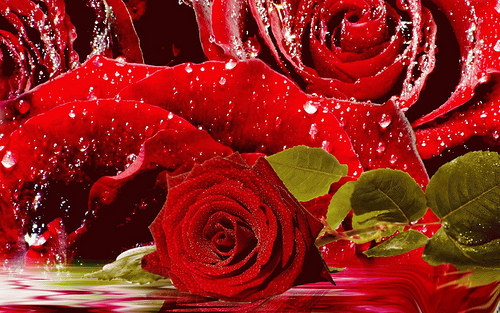

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[10]))

In [6]:
batch_size = 32
img_height = 220
img_width = 220

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 220, 220, 3)
(32,)


In [12]:
type(labels_batch[0])

tensorflow.python.framework.ops.EagerTensor

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [15]:
num_classes = 5

from tensorflow.keras.backend import clear_session

clear_session()
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.5),
  ]
)

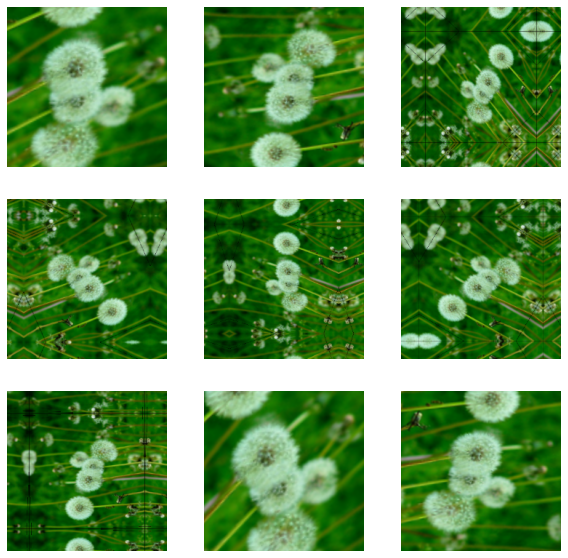

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epochs,log={}):
        if log.get('val_accuracy')>0.74:
            self.model.stop_training=True

In [22]:
from tensorflow.keras.backend import clear_session
clear_session()
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=myCallback())

Epoch 1/100
92/92 [==============================] - 20s 218ms/step - loss: 1.3932 - accuracy: 0.4135 - val_loss: 1.1483 - val_accuracy: 0.5259
Epoch 2/100
92/92 [==============================] - 20s 215ms/step - loss: 1.1499 - accuracy: 0.5136 - val_loss: 1.0206 - val_accuracy: 0.5749
Epoch 3/100
92/92 [==============================] - 20s 216ms/step - loss: 1.0645 - accuracy: 0.5743 - val_loss: 0.9564 - val_accuracy: 0.6063
Epoch 4/100
92/92 [==============================] - 20s 217ms/step - loss: 0.9965 - accuracy: 0.6076 - val_loss: 0.9352 - val_accuracy: 0.6362
Epoch 5/100
92/92 [==============================] - 20s 217ms/step - loss: 0.9483 - accuracy: 0.6322 - val_loss: 0.9124 - val_accuracy: 0.6294
Epoch 6/100
92/92 [==============================] - 20s 216ms/step - loss: 0.8886 - accuracy: 0.6509 - val_loss: 0.8218 - val_accuracy: 0.6744
Epoch 7/100


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
model.save('74.h5')

## Conv2D, Conv3D
## Maxpooling,Maxpool

## https://www.tensorflow.org/tutorials/images/classification